In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.metrics import accuracy_score
from sklearn.decomposition import PCA

In [2]:
df = pd.read_csv('./fulldata.csv')
df.head()

,Unnamed: 0,sp,word,round,order,Label,duration,timepoint,pF0_means,vqual,...,f0ST_means,vowelqual,f0ST_means_scaled,H1c_means_scaled,H1H2c_means_scaled,H1A1c_means_scaled,H1A2c_means_scaled,H1A3c_means_scaled,CPP_means_scaled,pF1_means_scaled
0,1,1,beard,1,49,uuH,125.892,1,240.535,breathy,...,27.194962,uu,0.303746,0.098379,0.137656,-0.085678,-0.005704,-0.406845,-0.421461,-1.133266
1,2,1,beard,2,6,uuH,107.982,1,247.509,breathy,...,27.689772,uu,0.355746,0.232261,0.097359,0.001183,0.095708,-0.390805,-0.515863,-1.237534
2,3,1,beard,3,33,uuH,142.940,1,244.426,breathy,...,27.472773,uu,0.332942,0.274019,0.107324,-0.109050,0.023509,-0.219512,-0.752780,-1.417865
3,4,1,beard,4,22,uuH,133.586,1,239.742,breathy,...,27.137792,uu,0.297738,0.236043,0.114589,-0.160673,0.036078,-0.488220,-0.255802,-1.504129
4,5,1,beard,5,50,uuH,160.248,1,246.624,breathy,...,27.627758,uu,0.349229,0.307570,0.076158,0.075996,-0.031587,-0.677209,-0.756971,-1.329145


In [3]:
df.columns

Index(['Unnamed: 0', 'sp', 'word', 'round', 'order', 'Label', 'duration',
       'timepoint', 'pF0_means', 'vqual', 'coda', 'onset', 'age', 'decade',
       'gender', 'yearsaway', 'experiencePC', 'famPC', 'awayPC', 'idPC',
       'pF1_means', 'CPP_means', 'H1c_means', 'H1H2c_means', 'H1A1c_means',
       'H1A2c_means', 'H1A3c_means', 'H2H4c_means', 'f0ST_means', 'vowelqual',
       'f0ST_means_scaled', 'H1c_means_scaled', 'H1H2c_means_scaled',
       'H1A1c_means_scaled', 'H1A2c_means_scaled', 'H1A3c_means_scaled',
       'CPP_means_scaled', 'pF1_means_scaled'],
      dtype='object')

We'll need it later, so let's get the demographic info from the main dataframe (kind of kludgey but got the job done), and save it to join up with the results later.

In [4]:
socialdf = df.groupby(['sp','age','decade','gender','yearsaway','experiencePC','famPC','awayPC',
                       'idPC']).mean().reset_index().iloc[:,:9].groupby(['sp','gender']).mean().reset_index()

There is a lot of data in here that we don't really need so let's take a moment to pare it down and then rename the relevant factors.

In [5]:
factors = ['f0ST_means_scaled', 'H1c_means_scaled', 'H1H2c_means_scaled',
       'H1A1c_means_scaled', 'H1A2c_means_scaled', 'H1A3c_means_scaled',
       'CPP_means_scaled', 'pF1_means_scaled']
factors_short = ['f0', 'H1c', 'H1H2c',
       'H1A1c', 'H1A2c', 'H1A3c',
       'CPP', 'F1']
renamecolumns = {factors[i]:factors_short[i] for i in range(len(factors))}
df = df.rename(columns=renamecolumns)

df = df[['sp','word','round','order','timepoint','Label','duration', 'vowelqual', 'vqual', 'coda', 'onset']+factors_short]
df.head()

,sp,word,round,order,timepoint,Label,duration,vowelqual,vqual,coda,onset,f0,H1c,H1H2c,H1A1c,H1A2c,H1A3c,CPP,F1
0,1,beard,1,49,1,uuH,125.892,uu,breathy,ʔ,p,0.303746,0.098379,0.137656,-0.085678,-0.005704,-0.406845,-0.421461,-1.133266
1,1,beard,2,6,1,uuH,107.982,uu,breathy,ʔ,p,0.355746,0.232261,0.097359,0.001183,0.095708,-0.390805,-0.515863,-1.237534
2,1,beard,3,33,1,uuH,142.940,uu,breathy,ʔ,p,0.332942,0.274019,0.107324,-0.109050,0.023509,-0.219512,-0.752780,-1.417865
3,1,beard,4,22,1,uuH,133.586,uu,breathy,ʔ,p,0.297738,0.236043,0.114589,-0.160673,0.036078,-0.488220,-0.255802,-1.504129
4,1,beard,5,50,1,uuH,160.248,uu,breathy,ʔ,p,0.349229,0.307570,0.076158,0.075996,-0.031587,-0.677209,-0.756971,-1.329145


We need to flatten the data by timepoint so that each row accounts for a single utterance.  At the same time, let's also reduce then number of timepoints to 10 because 20 is a lot!

In [6]:
timedf = df[df.timepoint==2][['sp','word','round','order','Label','duration', 'vowelqual', 'vqual', 'coda', 'onset']+factors_short]
timedf = timedf.rename(columns={"f0":"f0_2", "H1c":"H1c_2", "H1H2c":"H1H2c_2", "H1A1c":"H1A1c_2", "H1A2c":"H1A2c_2", "H1A3c":"H1A3c_2",
                                "CPP":"CPP_2", "F1":"F1_2"})

# this reduces the number of timepoints from 20 to 5, just to make things more manageable
for i in range(2,10):
    tmp = df[df.timepoint==i*2][['sp','word','round','order']+factors_short]
    tmp.columns = ['sp','word','round','order']+[f+'_'+str(i*2) for f in factors_short]
    timedf = timedf.merge(tmp)
    
timedf = timedf.dropna()
timedf.head()

,sp,word,round,order,Label,duration,vowelqual,vqual,coda,onset,...,CPP_16,F1_16,f0_18,H1c_18,H1H2c_18,H1A1c_18,H1A2c_18,H1A3c_18,CPP_18,F1_18
0,1,beard,1,49,uuH,125.892,uu,breathy,ʔ,p,...,-0.200946,0.172597,0.313914,-0.057147,0.200582,-0.170612,-0.041287,-0.304897,-0.233386,0.087034
1,1,beard,2,6,uuH,107.982,uu,breathy,ʔ,p,...,-0.394124,0.201707,0.298155,0.151401,0.259380,-0.271929,0.203834,-0.139793,-0.548120,0.194618
2,1,beard,3,33,uuH,142.940,uu,breathy,ʔ,p,...,-0.566527,0.599075,0.400459,0.170309,0.289950,0.147256,0.006636,-0.431035,-0.814924,0.162140
3,1,beard,4,22,uuH,133.586,uu,breathy,ʔ,p,...,-0.132787,0.604166,0.341111,0.170711,0.416995,-0.343310,-0.061374,-0.590952,-0.411438,0.517678
4,1,beard,5,50,uuH,160.248,uu,breathy,ʔ,p,...,-1.018490,0.043631,0.477850,-0.048940,0.006324,0.164424,-0.816823,-0.776541,-0.893836,0.268215


Define a function to return the accuracy of a trained LDA on a set of data.  This function takes in some data (x) and labels (y), trains an LDA on that data, then tests its accuracy using the same data, and returns the proportion of correctly labelled data points.

The idea here is that, all else being equal, if a speaker's breathy/modal contrast manifests wholly in voice quality measures (and not at all in pitch), a classifer trained on only voice quality measures will perform at or near 100% while a classifier trained on only f0 will perform at or near 50%.

In [7]:
def lda_acc(x, y):
    lda = LDA()
    X_train = lda.fit_transform(x,y)
    y_pred = lda.predict(x)

    return accuracy_score(y, y_pred)

Let's also take the time to define a few variables we might want to look at or play around with:
- pitch_factors: list of factors thought to directly relate to perception of pitch
- vq_factors: list of factors thought to directly relate to perception of voice quality
- explainP: the proportion of variance in the data we would like to be explained by the PCAs set up to reduce our pitch and voice quality space

In [8]:
pitch_factors = ['f0']
vq_factors = ['H1c','H1H2c','H1A1c','H1A2c','H1A3c','CPP']
explainP = 0.8

For each speaker
1. Use PCA to reduce the f0 time series data to the number of PCs that explain explainP% of the variation
1. Use PCA to reduce the voice quality time series data to the number of PCs that explain explainP% of the variation
1. Train and compare LDA classifiers on PCs from f0 only, PCs from voice quality only, and PCs from both combined

In [9]:
pcs = pd.DataFrame(columns=['sp','pitch','vq'])
accdf = pd.DataFrame(columns=['sp','acc_f0','acc_vq','acc_all'])

for s in df.sp.unique():
    tmpdf = timedf[timedf.sp==s]
    newdf = tmpdf.iloc[:,0:10].reset_index().iloc[:,1:]
    
    # Reduce f0 data to a number of PCs explaining explainP percent of the variation
    x = tmpdf[[f for f in tmpdf.columns if f.split('_')[0] in pitch_factors]]
    pca = PCA(n_components=explainP)
    principalComponents = pca.fit_transform(x)
    pitchpcs = len(principalComponents.T)
    newdf = pd.concat([newdf,
                       pd.DataFrame(principalComponents, 
                                    columns=['f0'+'_PC'+str(i+1) for i in range(0,len(principalComponents.T))])], 
                      axis=1)    

    # Reduce voice quality data to a number of PCs explaining explainP percent of the variation
    x = tmpdf[[f for f in tmpdf.columns if f.split('_')[0] in vq_factors]]
    pcavq = PCA(n_components=explainP)
    principalComponents = pcavq.fit_transform(x)
    vqpcs = len(principalComponents.T)
    pcs = pd.concat([pcs,pd.DataFrame([[s,pitchpcs, vqpcs]], columns=pcs.columns)])

    newdf = pd.concat([newdf,
                      pd.DataFrame(principalComponents, 
                                   columns=['vq_PC'+str(i+1) for i in range(0,len(principalComponents.T))])],
                     axis=1)
    
    x = newdf.iloc[:,10:]
    y = newdf.iloc[:,:10]
    
    f0_only = x[[f for f in newdf.columns if f.split('_')[0] == 'f0']]
    vq_only = x[[f for f in newdf.columns if f.split('_')[0] == 'vq']]
    full = pd.concat([f0_only,vq_only], axis=1)

    acc_f0 = lda_acc(f0_only, y.vqual)
    acc_vq = lda_acc(vq_only, y.vqual)
    acc_all = lda_acc(full, y.vqual)

    accdf = pd.concat([accdf,
                       pd.DataFrame([[s,acc_f0,acc_vq,acc_all]], columns=accdf.columns)],
                       axis=0)


Add demographic information

In [10]:
resultsdf = socialdf.merge(accdf)
resultsdf.decade = resultsdf.decade.astype(str)
resultsdf.head()

,sp,gender,age,decade,yearsaway,experiencePC,famPC,awayPC,idPC,acc_f0,acc_vq,acc_all
0,1,f,31,30,7.0,-1.043926,-0.228534,0.811728,-0.218302,0.780000,0.860000,0.880000
1,2,m,34,30,0.0,-0.779533,0.750860,-1.048702,-0.590100,0.763636,0.909091,0.909091
2,3,m,50,50,0.0,0.129850,0.502381,-1.470801,1.373952,0.779221,0.961039,1.000000
3,4,m,27,20,3.0,-0.097690,1.413516,0.412594,-1.076652,0.633333,0.866667,0.922222
4,5,f,22,20,0.0,-2.169840,-0.106268,-1.211306,0.058194,0.681818,0.875000,0.931818


The next cells reshape the data so that all of the data from a single production is in a single row.  At the same time, I'll make the factors a little easier to read.

This figure shows that overall, all speakers use voice quality acoustic cues (acc_vq) in their contrast between breathy and modal, and that no speaker uses f0 cues to a greater extent than they use voice quality cues. 

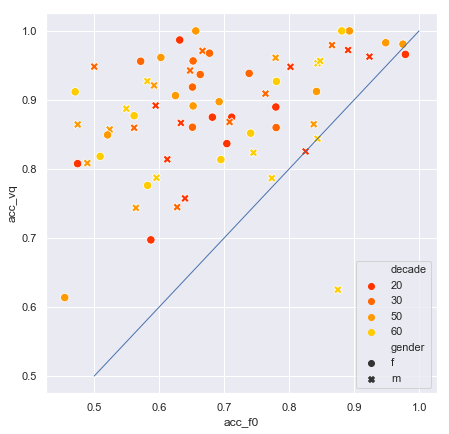

In [11]:
sns.set(rc={'figure.figsize':(7,7)})
splot = sns.scatterplot(x='acc_f0',y='acc_vq',style='gender',
                        hue='decade',palette=sns.color_palette("autumn",n_colors=len(resultsdf.decade.unique())),s=70,
                        data=resultsdf)
plt.plot([0.5, 1], [0.5, 1], linewidth=1)

In [12]:
resultsdf['improve'] = (resultsdf.acc_vq-resultsdf.acc_f0)/resultsdf.acc_vq
resultsdf.head()

,sp,gender,age,decade,yearsaway,experiencePC,famPC,awayPC,idPC,acc_f0,acc_vq,acc_all,improve
0,1,f,31,30,7.0,-1.043926,-0.228534,0.811728,-0.218302,0.780000,0.860000,0.880000,0.093023
1,2,m,34,30,0.0,-0.779533,0.750860,-1.048702,-0.590100,0.763636,0.909091,0.909091,0.160000
2,3,m,50,50,0.0,0.129850,0.502381,-1.470801,1.373952,0.779221,0.961039,1.000000,0.189189
3,4,m,27,20,3.0,-0.097690,1.413516,0.412594,-1.076652,0.633333,0.866667,0.922222,0.269231
4,5,f,22,20,0.0,-2.169840,-0.106268,-1.211306,0.058194,0.681818,0.875000,0.931818,0.220779


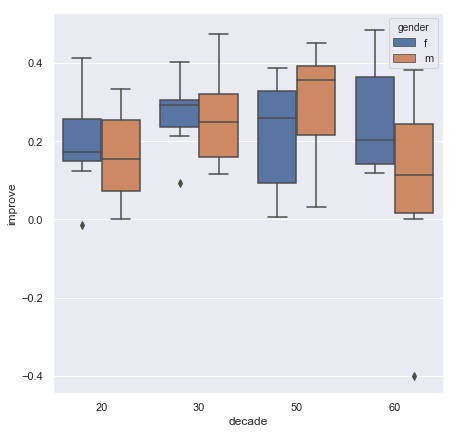

In [13]:
sns.boxplot(x='decade',y='improve',hue='gender',data=resultsdf)